In [3]:
#1. Data Exploration and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (adjust path or use online source)
df = pd.read_csv('adult_with_headers.csv')

# Basic exploration
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())  # Check missing values

# Note: In the Adult dataset, missing values are often marked as '?'
# Replace '?' with np.nan
df.replace('?', np.nan, inplace=True)
print(df.isnull().sum())  # Now check missing values again


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                 age workclass        fnlwgt education  education_num  \
count   32561.0

In [4]:
#Handling Missing Values
# Option 1: Remove rows with missing values (simple but can lose data)
df_clean = df.dropna()

# Option 2: Impute missing values (better if missingness is low)
# For categorical columns, impute with mode
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


C:\Users\APPY\AppData\Local\Temp\ipykernel_12296\1956055458.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\APPY\AppData\Local\Temp\ipykernel_12296\1956055458.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [5]:
#Scaling Numerical Features
num_cols = df_clean.select_dtypes(include=np.number).columns

# Standard Scaling (mean=0, std=1)
scaler_std = StandardScaler()
df_clean_std = df_clean.copy()
df_clean_std[num_cols] = scaler_std.fit_transform(df_clean[num_cols])

# Min-Max Scaling (scale to [0,1])
scaler_mm = MinMaxScaler()
df_clean_mm = df_clean.copy()
df_clean_mm[num_cols] = scaler_mm.fit_transform(df_clean[num_cols])


In [6]:
#When to use each scaling?
#Standard Scaling is preferred when data follows approximately a normal distribution, and you want to center it around zero with unit variance. It is robust for algorithms assuming Gaussian distribution (e.g., logistic regression, SVM).

#Min-Max Scaling is useful when you want all features within a fixed range, typically [0,1], useful for algorithms that require bounded input like neural networks or when preserving zero entries is important.

In [7]:
#2. Encoding Techniques
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = df_clean.select_dtypes(include='object').columns

# Separate categorical columns based on number of unique values
onehot_cols = [col for col in cat_cols if df_clean[col].nunique() < 5]
labelenc_cols = [col for col in cat_cols if df_clean[col].nunique() >= 5]

# One-Hot Encoding for low cardinality categorical features
df_encoded = pd.get_dummies(df_clean, columns=onehot_cols)

# Label Encoding for high cardinality categorical features
label_encoders = {}
for col in labelenc_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le


In [8]:
#| Encoding Type        | Pros                                         | Cons                                                                       |
#| -------------------- | -------------------------------------------- | -------------------------------------------------------------------------- |
#| **One-Hot Encoding** | Does not assume any order, easy to interpret | Can create many features if categories are large (curse of dimensionality) |
#| **Label Encoding**   | Simple and efficient                         | Imposes ordinal relationship where none may exist, can mislead some models |


In [9]:
print(df_encoded.columns.tolist())

['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'sex_ Female', 'sex_ Male', 'income_ <=50K', 'income_ >50K']


In [10]:
def skill_level(row):
    if row['education_num'] >= 13 and row['occupation'] in ['Exec-managerial', 'Prof-specialty']:
        return 'high_skill'
    elif row['education_num'] < 13 and row['occupation'] in ['Craft-repair', 'Machine-op-inspct']:
        return 'medium_skill'
    else:
        return 'low_skill'

In [11]:
df_encoded['skill_level'] = df_encoded.apply(skill_level, axis=1)
df_encoded['hours_per_week_high'] = (df_encoded['hours_per_week'] > 40).astype(int)

In [12]:
#3. Feature Engineering
#Creating new features:
# 1. Combine education and occupation into a new feature indicating skill level
def skill_level(row):
    if row['education_num'] >= 13 and row['occupation'] in ['Exec-managerial', 'Prof-specialty']:
        return 'high_skill'
    elif row['education_num'] < 13 and row['occupation'] in ['Craft-repair', 'Machine-op-inspct']:
        return 'medium_skill'
    else:
        return 'low_skill'

df_encoded['skill_level'] = df_encoded.apply(skill_level, axis=1)

# 2. Create a binary feature: 'hours_per_week_high' indicating if hours_per_week > 40
df_encoded['hours_per_week_high'] = (df_encoded['hours_per_week'] > 40).astype(int)


In [13]:
#Transformation of skewed numerical feature
# Check skewness
skew_vals = df_encoded[num_cols].skew()
print(skew_vals)

# Apply log transformation on 'capital-gain' which is usually skewed
df_encoded['capital_gain_log'] = np.log1p(df_encoded['capital_gain'])



age                0.558743
fnlwgt             1.446980
education_num     -0.311676
capital_gain      11.953848
capital_loss       4.594629
hours_per_week     0.227643
dtype: float64


In [14]:
#4. Feature Selection
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df_encoded[num_cols])

# -1 indicates outliers, 1 indicates inliers
df_no_outliers = df_encoded[outliers == 1]

print(f"Removed {sum(outliers == -1)} outliers")

Removed 326 outliers


In [15]:
#pip install --no-deps ppscore

In [18]:
print(df_no_outliers.shape)

(32235, 20)


In [19]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)  # Try 5% instead of a higher number
outliers = iso.fit_predict(df_encoded.select_dtypes(include='number'))
df_no_outliers = df_encoded[outliers == 1]

In [22]:
# Only include numeric columns
numeric_df = df_no_outliers.select_dtypes(include='number')

In [27]:
import ppscore as pps

# Compute PPS matrix
pps_matrix = pps.matrix(df_no_outliers)

# Display relationships where 'income' is the predictor (x)
print(pps_matrix[pps_matrix['x'] == 'income'].sort_values(by='ppscore', ascending=False))



Empty DataFrame
Columns: [x, y, ppscore, case, is_valid_score, metric, baseline_score, model_score, model]
Index: []


In [28]:
# Display relationships where income is the target (y)
print(pps_matrix[pps_matrix['y'] == 'income_ >50K'].sort_values(by='ppscore', ascending=False))


                       x             y       ppscore            case  \
336         income_ >50K  income_ >50K  1.000000e+00  predict_itself   
316        income_ <=50K  income_ >50K  1.000000e+00  classification   
396     capital_gain_log  income_ >50K  2.272578e-01  classification   
196         capital_gain  income_ >50K  2.272578e-01  classification   
76             education  income_ >50K  2.115973e-01  classification   
96         education_num  income_ >50K  2.115973e-01  classification   
136           occupation  income_ >50K  1.603982e-01  classification   
216         capital_loss  income_ >50K  1.160551e-01  classification   
236       hours_per_week  income_ >50K  3.225861e-02  classification   
36             workclass  income_ >50K  1.612036e-02  classification   
16                   age  income_ >50K  6.522576e-03  classification   
56                fnlwgt  income_ >50K  5.757988e-03  classification   
116       marital_status  income_ >50K  2.248644e-03  classifica

C:\Users\APPY\AppData\Local\Temp\ipykernel_12296\2721137389.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pps_income.head(10), x='ppscore', y='x', palette='viridis')


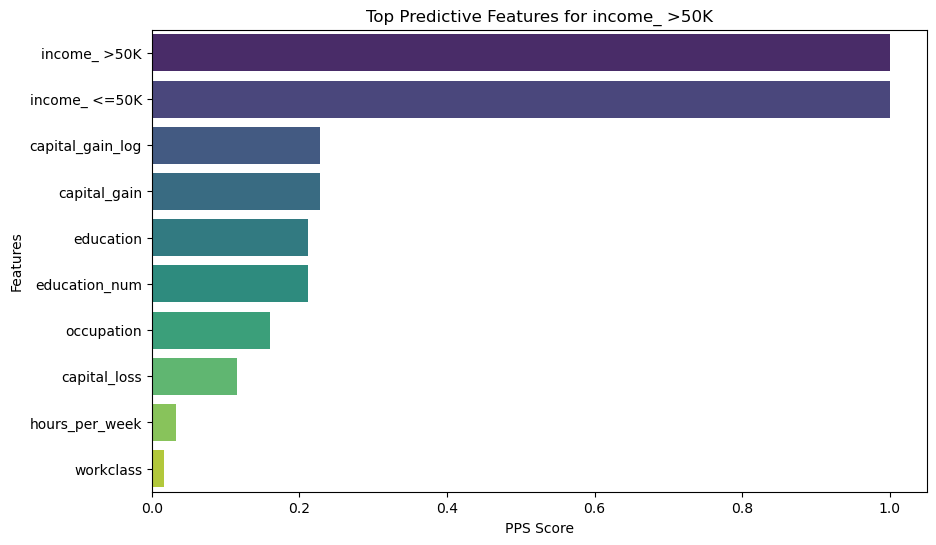

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only rows where y = 'income_ >50K' and sort by PPS score
pps_income = pps_matrix[pps_matrix['y'] == 'income_ >50K'].sort_values(by='ppscore', ascending=False)

# Plot top predictors
plt.figure(figsize=(10,6))
sns.barplot(data=pps_income.head(10), x='ppscore', y='x', palette='viridis')
plt.title("Top Predictive Features for income_ >50K")
plt.xlabel("PPS Score")
plt.ylabel("Features")
plt.show()



In [ ]:
#Summary
#Data preprocessing involves cleaning missing values and scaling features appropriately.

#Encoding methods must be chosen based on cardinality and the nature of categorical data.

#Feature engineering can add predictive power through new features and transformations.

#Outlier detection/removal improves model robustness.

#PPS offers a more flexible approach to understand predictive relationships than correlation alone.